<a href="https://colab.research.google.com/github/daiweiworking/BenchmarkDeepLearning/blob/master/Making_the_Most_of_your_Colab_Subscription.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Making the Most of your Colab Subscription



## Faster GPUs

With Colab Pro you have priority access to our fastest GPUs. For example, you may get a T4 or P100 GPU at times when most users of standard Colab receive a slower K80 GPU. You can see what GPU you've been assigned at any time by executing the following cell.

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Tue Jul 27 15:31:25 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

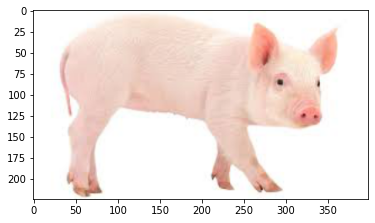

In [3]:
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt

# read the image, resize to 224 and convert to PyTorch Tensor
pig_img = Image.open("pig.jpg")
preprocess = transforms.Compose([
   transforms.Resize(224),
   transforms.ToTensor(),
])
pig_tensor = preprocess(pig_img)[None,:,:,:]

# plot image (note that numpy using HWC whereas Pytorch user CHW, so we need to convert)
plt.imshow(pig_tensor[0].numpy().transpose(1,2,0))

In order to use a GPU with your notebook, select the Runtime > Change runtime type menu, and then set the hardware accelerator dropdown to GPU.

## More memory

With Colab Pro you have the option to access high-memory VMs when they are available. To set your notebook preference to use a high-memory runtime, select the Runtime > 'Change runtime type' menu, and then select High-RAM in the Runtime shape dropdown.

You can see how much memory you have available at any time by running the following code.


In [4]:
import torch
import torch.nn as nn
from torchvision.models import resnet50

# simple Module to normalize an image
class Normalize(nn.Module):
    def __init__(self, mean, std):
        super(Normalize, self).__init__()
        self.mean = torch.Tensor(mean)
        self.std = torch.Tensor(std)
    def forward(self, x):
        return (x - self.mean.type_as(x)[None,:,None,None]) / self.std.type_as(x)[None,:,None,None]

# values are standard normalization for ImageNet images, 
# from https://github.com/pytorch/examples/blob/master/imagenet/main.py
norm = Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# load pre-trained ResNet50, and put into evaluation mode (necessary to e.g. turn off batchnorm)
model = resnet50(pretrained=True)
model.eval();
pred = model(norm(pig_tensor))



Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [9]:
#!wget https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json
import json
with open("imagenet_class_index.json") as f:
    imagenet_classes = {int(i):x[1] for i,x in json.load(f).items()}

max_class = pred.max(dim=1)[1].item()
print(imagenet_classes[max_class])
print(nn.CrossEntropyLoss()(model(norm(pig_tensor)),torch.LongTensor([341])).item())
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

diaper
0.05511913448572159
Predicted probability: 0.9971092343330383


In [27]:
import torch.optim as optim
epsilon = 2./255

delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=1e-1)

for t in range(50):
    pred = model(norm(pig_tensor - delta))
    loss = -nn.CrossEntropyLoss()(pred, torch.LongTensor([341]))
    if t % 5 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)
    
#print("True class probability:", nn.Softmax(dim=1)(pred)[0,341].item())
max_class = pred.max(dim=1)[1].item()
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

0 -0.05511913448572159
5 -17.183143615722656
10 -18.23106575012207
15 -22.421173095703125
20 -22.684213638305664
25 -23.872236251831055
30 -25.553354263305664
35 -17.934602737426758
40 -23.760536193847656
45 -20.59208106994629
Predicted class:  diaper
Predicted probability: 0.9971092343330383


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


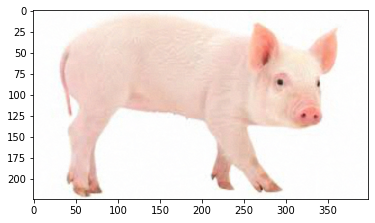

In [28]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))


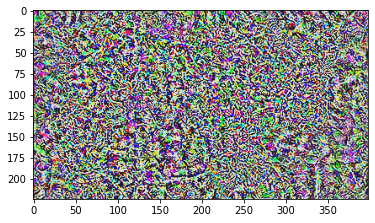

In [12]:
plt.imshow((0.5+ 50* delta)[0].detach().numpy().transpose(1,2,0))

In [19]:
delta = torch.zeros_like(pig_tensor, requires_grad=True)
opt = optim.SGD([delta], lr=5e-3)

for t in range(100):
    pred = model(norm(pig_tensor + delta))
    loss = (-nn.CrossEntropyLoss()(pred, torch.LongTensor([341])) + 
            nn.CrossEntropyLoss()(pred, torch.LongTensor([405])))
    if t % 10 == 0:
        print(t, loss.item())
    
    opt.zero_grad()
    loss.backward()
    opt.step()
    delta.data.clamp_(-epsilon, epsilon)

0 11.613966941833496
10 -11.043045043945312
20 -31.129907608032227
30 -46.72001266479492
40 -52.075050354003906
50 -60.65092468261719
60 -70.70511627197266
70 -70.64808654785156
80 -75.93986511230469
90 -73.72622680664062


In [20]:
max_class = pred.max(dim=1)[1].item()
print('class_id', max_class)
print("Predicted class: ", imagenet_classes[max_class])
print("Predicted probability:", nn.Softmax(dim=1)(pred)[0,max_class].item())

class_id 405
Predicted class:  airship
Predicted probability: 1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


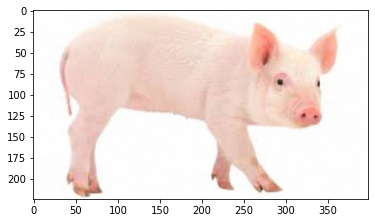

In [22]:
plt.imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

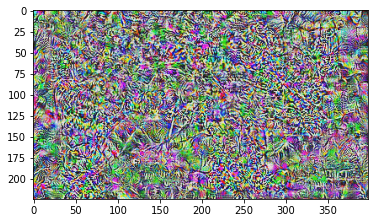

In [24]:
plt.imshow((50*delta+0.5)[0].detach().numpy().transpose(1,2,0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


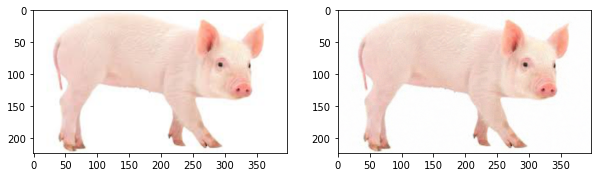

In [29]:
f,ax = plt.subplots(1,2, figsize=(10,5))
ax[0].imshow((pig_tensor)[0].detach().numpy().transpose(1,2,0))
ax[1].imshow((pig_tensor + delta)[0].detach().numpy().transpose(1,2,0))

## Longer runtimes

All Colab runtimes are reset after some period of time (which is faster if the runtime isn't executing code). While Colab Pro subscribers still have limits, these will be roughly twice the limits for non-subscribers.

## Resource limits in Colab Pro

Your resources are not unlimited in Colab Pro. To make the most of Colab Pro, please avoid using resources when you don't need them. For example, only use a GPU or high-RAM runtime when required, and close Colab tabs when finished.


## Send us feedback!

If you have any feedback for us, please let us know. The best way to send feedback is by using the Help > 'Send feedback...' menu. If you encounter usage limits in Colab Pro and would be interested in a product with higher usage limits, do let us know.

If you encounter errors or other issues with billing (payments) for Colab Pro, please email [colab-billing@google.com](mailto:colab-billing@google.com).